# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review



In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\LiGht\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000, will give top 100000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:53<00:00, 1627.49it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [25]:
from sklearn import datasets, neighbors
final['CleanedText']=preprocessed_reviews
print(final.shape)
final.head(3)

(87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...


In [26]:
labels=final['Score'].values

# Picking the top 3000 points as TSNE
X = final['CleanedText'].values
Y = labels[0:100000]

In [27]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100) 

(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)
After vectorizations
(39400, 37580) (39400,)
(19407, 37580) (19407,)
(28966, 37580) (28966,)


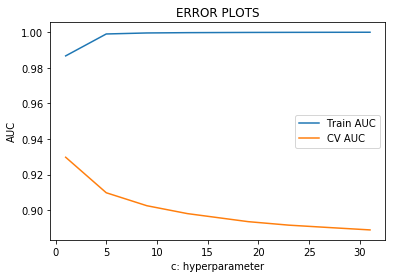

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg=LogisticRegression(penalty="l1",C=c)
                              
    logreg.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  logreg.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [29]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c = 1


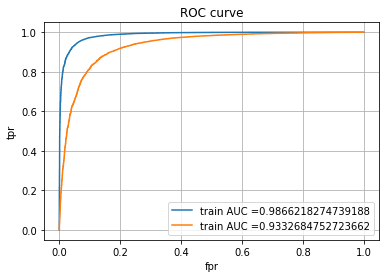

In [31]:
from sklearn.metrics import roc_curve, auc


logreg=LogisticRegression(penalty="l1",C=best_c)
                              
logreg.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg.predict_proba(X_train_bow)[:,1]
y_test_pred = logreg.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()


In [32]:
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [33]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8910841292041622 for threshold 0.759
Train confusion matrix
[[ 6004   401]
 [ 1630 31365]]
Test confusion matrix
[[ 3690   978]
 [ 1849 22449]]


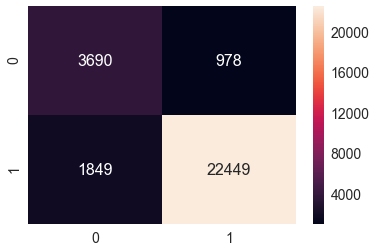

In [34]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [35]:
# Please write all the code with proper documentation
from sklearn.metrics import f1_score
logreg=LogisticRegression(C=1,penalty='l1')
logreg.fit(X_train_bow, y_train)
pred = logreg.predict(X_cv_bow)
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nCV accuracy is %d%%' % (acc))
f1=f1_score(y_cv, pred)
print('\nCV f1 score is %0.3d' % (f1_score(y_cv, pred)))
print("non zero weight:",np.count_nonzero(logreg.coef_))


CV accuracy is 91%

CV f1 score is 000
non zero weight: 3508


In [36]:
#since there is low non zero weights so the sparsity of cv_data of bow is high

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

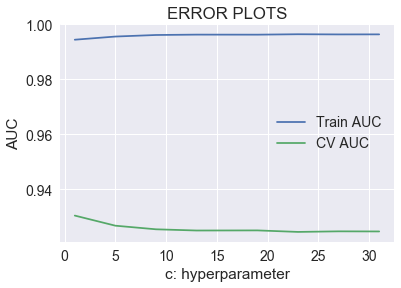

In [37]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg=LogisticRegression(penalty="l2",C=c)
                              
    logreg.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  logreg.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [38]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c = 1


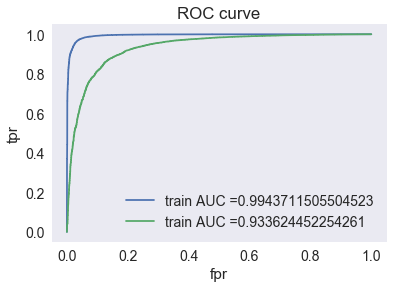

In [39]:
from sklearn.metrics import roc_curve, auc


logreg=LogisticRegression(penalty="l2",C=best_c)
                              
logreg.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg.predict_proba(X_train_bow)[:,1]
y_test_pred = logreg.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

In [40]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9350012746472717 for threshold 0.734
Train confusion matrix
[[ 6157   248]
 [  902 32093]]
Test confusion matrix
[[ 3607  1061]
 [ 1641 22657]]


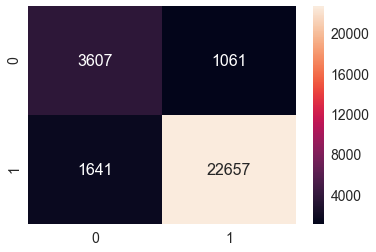

In [41]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [42]:
#taking hiny from https://raw.githubusercontent.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling
logreg=LogisticRegression(C=10,penalty='l2')
logreg.fit(X_train_bow, y_train)
pred = logreg.predict(X_cv_bow)
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nCV accuracy is %d%%' % (acc))
print("non zero weight:",np.count_nonzero(logreg.coef_))


CV accuracy is 91%
non zero weight: 37580


In [43]:
print(X_train_bow.shape)

(39400, 37580)


In [44]:
w1=logreg.coef_
print(w1[:50])

[[-4.56687692e-02  1.76334666e-02  2.10715750e-02 ...  1.31745212e-04
  -1.98683716e-01  1.57031117e-01]]


In [45]:
np.random.uniform(-0.01,0.01)

-0.0068097266967916785

In [46]:
from copy import deepcopy
X_train_bow1 = deepcopy(X_train_bow)


In [47]:
#random noise
epsilon=np.random.normal(0,0.001)



In [48]:
epsilon

-0.0014665892861252846

In [49]:
X_train_bow1.data=X_train_bow1.data+epsilon

In [50]:
print(X_train_bow1.shape)

(39400, 37580)


In [51]:
logreg=LogisticRegression(C=10,penalty='l2')
logreg.fit(X_train_bow1, y_train)
pred = logreg.predict(X_cv_bow)
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nCV accuracy is %d%%' % (acc))
print("non zero weight:",np.count_nonzero(logreg.coef_))


CV accuracy is 91%
non zero weight: 37580


In [52]:
w2=logreg.coef_
print(w1[:50])

[[-4.56687692e-02  1.76334666e-02  2.10715750e-02 ...  1.31745212e-04
  -1.98683716e-01  1.57031117e-01]]


In [53]:

w1=w1+10**-6
w2=w2+10**-6

In [54]:
print(w1.shape)

(1, 37580)


In [55]:
print(w2.shape)

(1, 37580)


In [56]:
#weight difference
w_diff=(abs(w1-w2)/w1)*100

In [57]:
print(w_diff[np.where(w_diff>0)].size)

25790


In [58]:
print(np.percentile(w_diff,0))

-3720.9218548906533


In [59]:
print(np.percentile(w_diff,10))

-2.5965637562140707


In [60]:
print(np.percentile(w_diff,20))

-1.273217571234689


In [61]:
print(np.percentile(w_diff,30))

-0.16571087879790797


In [62]:
print(np.percentile(w_diff,40))

0.41532611910767664


In [63]:
print(np.percentile(w_diff,50))

0.7912451609378588


In [64]:
print(np.percentile(w_diff,60))

1.210582490878563


In [65]:
print(np.percentile(w_diff,70))

1.8556226595245189


In [66]:
print(np.percentile(w_diff,80))

2.512095278985422


In [67]:
print(np.percentile(w_diff,90))

3.5310340276100076


In [68]:
print(np.percentile(w_diff,100))

1290.5514428866954


In [69]:
print(np.percentile(w_diff,91))
print(np.percentile(w_diff,92))
print(np.percentile(w_diff,93))
print(np.percentile(w_diff,94))
print(np.percentile(w_diff,95))
print(np.percentile(w_diff,96))
print(np.percentile(w_diff,97))
print(np.percentile(w_diff,98))
print(np.percentile(w_diff,99))


3.6952830731505593
3.878498517151808
4.088135971385726
4.372050114735554
4.793743307042764
5.388022736688556
6.41868817209425
8.576938095267263
17.756415816649316


# Top 10 important features of positive and Negative class from SET 1

In [70]:
coef_=logreg.coef_
coef_

array([[-4.23472373e-02,  1.74175363e-02,  2.07989321e-02, ...,
         1.32043524e-04, -1.94223138e-01,  1.51386639e-01]])

In [71]:
sorted_coef=np.sort(coef_)


In [72]:
print(sorted_coef)

[[-4.20779622 -3.63555519 -3.14643357 ...  2.50028279  2.76959
   3.305223  ]]


In [73]:
def smif(vectorizer,clf,n=10):
    feature_names=vectorizer.get_feature_names()
    coef_with_fn=sorted(zip(clf.coef_[0],feature_names))
    top=zip(coef_with_fn[:n],coef_with_fn[:-(n+1):-1])
    print("\t\t\tPositive\t\t\t\t\tNegative")
    for (coef_1,fn_1),(coef_2,fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.f\t%-15s"%(coef_1,fn_1,coef_2,fn_2))
smif(vectorizer,logreg)

			Positive					Negative
	-4.2078	worst          				3	pleasantly     
	-3.6356	rip            				3	fantastic      
	-3.1464	disappointment 				3	delicious      
	-3.1421	disappointing  				2	yummy          
	-3.1145	undrinkable    				2	beat           
	-3.0148	cancelled      				2	worried        
	-2.9581	threw          				2	downside       
	-2.9229	awful          				2	hooked         
	-2.8195	terrible       				2	forest         
	-2.7410	shame          				2	suck           


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [74]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)
After vectorizations
(39400, 23565) (39400,)
(19407, 23565) (19407,)
(28966, 23565) (28966,)


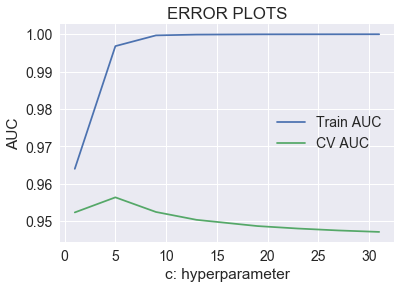

In [75]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg1=LogisticRegression(penalty="l1",C=c)
                              
    logreg1.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg1.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  logreg1.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [76]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c = 1

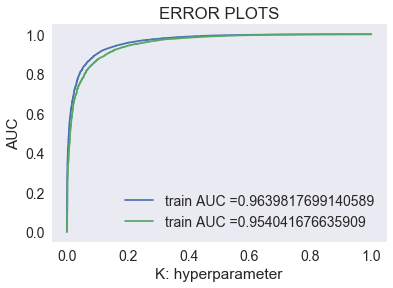

In [77]:
from sklearn.metrics import roc_curve, auc


logreg1=LogisticRegression(penalty="l1",C=best_c)
                              
logreg1.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg1.predict_proba(X_train_tfidf)[:,1]
y_test_pred = logreg1.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [78]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8130129348833591 for threshold 0.802
Train confusion matrix
[[ 5680   639]
 [ 3160 29921]]
Test confusion matrix
[[ 4096   616]
 [ 2421 21833]]


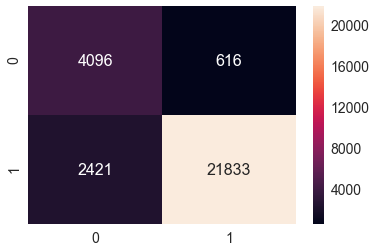

In [79]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

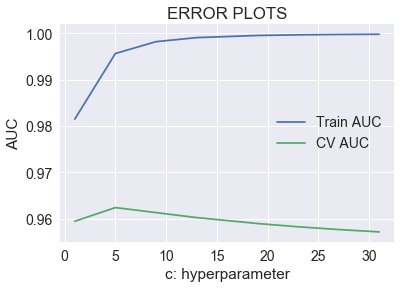

In [80]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg1=LogisticRegression(penalty="l2",C=c)
                              
    logreg1.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg1.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  logreg1.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [81]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 11

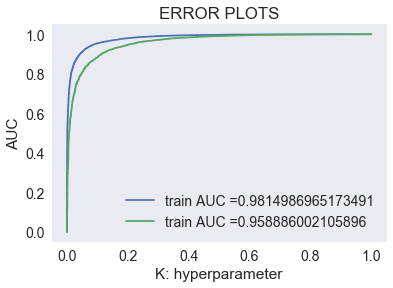

In [82]:
from sklearn.metrics import roc_curve, auc


logreg1=LogisticRegression(penalty="l2",C=best_c)
                              
logreg1.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg1.predict_proba(X_train_tfidf)[:,1]
y_test_pred = logreg1.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [83]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8698571464989814 for threshold 0.778
Train confusion matrix
[[ 5906   413]
 [ 2293 30788]]
Test confusion matrix
[[ 4082   630]
 [ 2019 22235]]


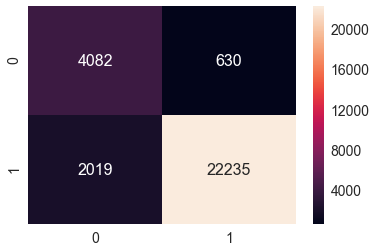

In [84]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of negative and positive class from<font color='red'> SET 2</font>

In [85]:
# Please write all the code with proper documentation
def smif(vectorizer,clf,n=10):
    feature_names=vectorizer.get_feature_names()
    coef_with_fn=sorted(zip(clf.coef_[0],feature_names))
    top=zip(coef_with_fn[:n],coef_with_fn[:-(n+1):-1])
    print("\t\t\tPositive\t\t\t\t\tNegative")
    print("_______________________________________________________________________________")
    for (coef_1,fn_1),(coef_2,fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.f\t%-15s"%(coef_1,fn_1,coef_2,fn_2))
smif(vectorizer,logreg1)

			Positive					Negative
_______________________________________________________________________________
	-7.1255	certain        				10	dialed         
	-6.9710	glitterwhilst  				7	appointment    
	-5.8118	overpaying     				7	carmelize      
	-5.3169	mnc            				6	delilah        
	-5.0735	dosesof        				6	hodl           
	-5.0024	certification  				6	faucets        
	-4.9619	amoxicillin    				5	fibers         
	-4.8808	greemies       				5	generation     
	-4.8439	goodberrymint  				5	collge         
	-4.5055	granddad       				5	outweighs      


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [86]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [87]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [88]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11997
sample words  ['product', 'never', 'received', 'nor', 'money', 'returned', 'four', 'requests', 'ignored', 'probably', 'order', 'anything', 'amazon', 'also', 'spread', 'word', 'sites', 'bought', 'occupy', 'mix', 'aggressive', 'chewer', 'description', 'led', 'believe', 'toy', 'quite', 'tough', 'little', 'saw', 'tug', 'rubber', 'rather', 'rope', 'appears', 'picture', 'tends', 'get', 'toys', 'effort', 'nevertheless', 'decided', 'try', 'learned', 'quickly', 'could', 'treats', 'occupied', 'well', 'almost']


In [89]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 39400/39400 [01:44<00:00, 378.14it/s]


(39400, 50)
[-0.78180017 -0.76784392 -0.16094907  0.07642277 -0.24356734  0.36456115
 -0.28768478  0.39409896 -0.27140376  0.62286451  0.00990244  0.22083216
 -0.26373026 -0.54248273  0.38546598 -0.31993674 -0.00818187 -0.46458444
  0.16325666  0.1751945  -0.22778622 -0.14915177  0.21522112  0.49613409
  0.24378172  0.83957056  0.41276515 -0.47495467 -0.34055447 -0.00547631
  0.87249768  0.19490085 -0.14789385 -0.44169222  0.490077   -0.39856302
  0.2052361  -0.08584059 -0.22231813 -0.99367253  0.48909674  0.34625549
  0.11635209 -0.06543135  0.12797689  0.2187971   0.17243647  0.14974605
 -0.82807003  0.05472181]


In [90]:
#converting cv data to text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [91]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 19407/19407 [00:54<00:00, 355.78it/s]


(19407, 50)
[-0.13556181 -0.18168149  0.47974714 -0.0459962   0.25985915  0.46761487
 -0.27077147 -0.05329503 -0.07203044  0.31725257 -0.12387034 -0.3580247
 -0.18566813 -0.01814503 -0.10517106 -0.12767017  0.36696426 -0.04199448
  0.08473547  0.54112631 -0.18674729  0.22243222 -0.34355988  0.08594326
 -0.01066194  0.63636967 -0.3572629   0.4914431  -0.10033133  0.09447615
  0.38251955  0.33163027 -0.11347683  0.03838402  0.4952115   0.11875431
  0.02834431  0.2474678  -0.44503682 -0.5629101   0.58164803  0.31157989
  0.2130757  -0.29410026  0.70609585  0.70045755 -0.2145785  -0.19147371
 -0.90529551  0.24276965]


In [92]:
#Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [93]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [01:17<00:00, 374.98it/s]


(28966, 50)
[-0.07137153 -0.23758367 -0.07821616  0.28007781  0.44196227  0.34940875
 -0.17490703 -0.28577259 -0.17451503  0.07661905 -0.2013256  -0.52505478
  0.11930505  0.05434604 -0.14115794 -0.90259519 -0.48371648 -0.05043002
 -0.28935131  0.08101319 -0.55276567 -0.39218051  0.16069293 -0.42043993
  0.58425171  0.82589905 -0.69898665  0.37498182  0.15716065  0.07377689
  0.27179088  0.21740526  0.03874749 -0.18496582  0.78605361 -0.02766161
 -0.01022155  0.64960897 -0.23700955 -0.36982552  0.6653905   0.22605173
 -0.0736446  -0.05951173  0.53076183  1.02020345  0.0125747  -0.25242538
 -0.68383353  0.43331699]


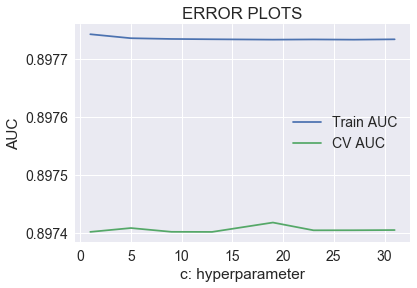

In [94]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg2=LogisticRegression(penalty="l1",C=c)
                              
    logreg2.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg2.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  logreg2.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [95]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c= 1

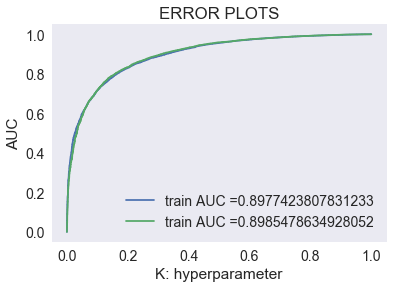

In [96]:
from sklearn.metrics import roc_curve, auc


logreg2=LogisticRegression(penalty="l1",C=best_c)
                              
logreg2.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg2.predict_proba(sent_vectors_train)[:,1]
y_test_pred = logreg2.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [97]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6685864247456904 for threshold 0.826
Train confusion matrix
[[ 5213  1106]
 [ 6271 26810]]
Test confusion matrix
[[ 3894   818]
 [ 4514 19740]]


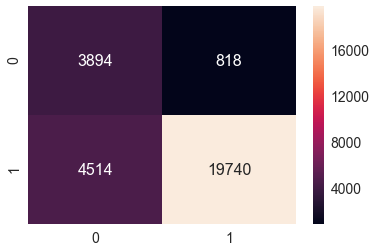

In [98]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

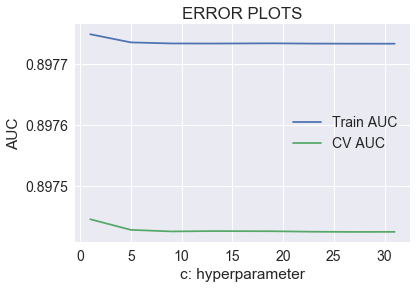

In [99]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg2=LogisticRegression(penalty="l2",C=c)
                              
    logreg2.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg2.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  logreg2.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [100]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c = 1

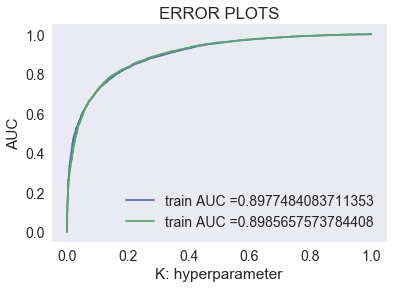

In [101]:
from sklearn.metrics import roc_curve, auc


logreg2=LogisticRegression(penalty="l2",C=best_c)
                              
logreg2.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg2.predict_proba(sent_vectors_train)[:,1]
y_test_pred = logreg2.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [102]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6687826323030813 for threshold 0.832
Train confusion matrix
[[ 5265  1054]
 [ 6528 26553]]
Test confusion matrix
[[ 3930   782]
 [ 4677 19577]]


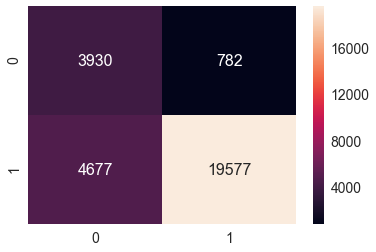

In [103]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)


In [105]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [106]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 39400/39400 [21:43<00:00, 30.23it/s]


In [107]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [108]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 19407/19407 [06:34<00:00, 49.21it/s]


In [109]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [110]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 28966/28966 [15:15<00:00, 24.27it/s]


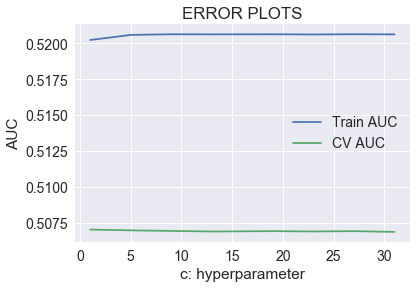

In [121]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg3=LogisticRegression(penalty="l1",C=c)
                              
    logreg3.fit(tfidf_train_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg3.predict_proba(tfidf_train_sent_vectors)[:,1]
    y_cv_pred =  logreg3.predict_proba(tfidf_cv_sent_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [122]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_c = 1

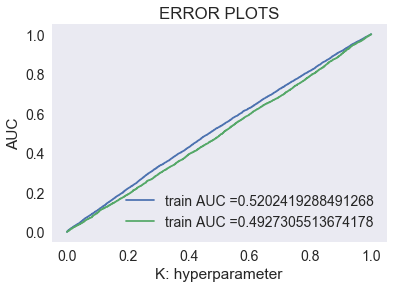

In [123]:
from sklearn.metrics import roc_curve, auc


logreg3=LogisticRegression(penalty="l1",C=best_c)
                              
logreg3.fit(tfidf_train_sent_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg3.predict_proba(tfidf_train_sent_vectors)[:,1]
y_test_pred = logreg3.predict_proba(tfidf_test_sent_vectors)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [114]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.2670534033336905 for threshold 0.84
Train confusion matrix
[[ 3231  3089]
 [15800 17280]]
Test confusion matrix
[[ 2234  2490]
 [11687 12555]]


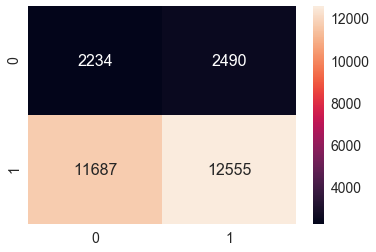

In [115]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

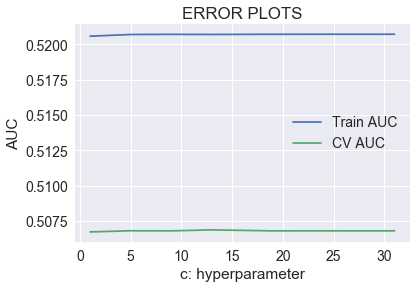

In [116]:
train_auc = []
cv_auc = []
K = [1,5,9,13,19,23,27,31]
for c in K:
    logreg3=LogisticRegression(penalty="l2",C=c)
                              
    logreg3.fit(tfidf_train_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputslogreg.predict_proba(X_train_bow)
    y_train_pred =  logreg3.predict_proba(tfidf_train_sent_vectors)[:,1]
    y_cv_pred =  logreg3.predict_proba(tfidf_cv_sent_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

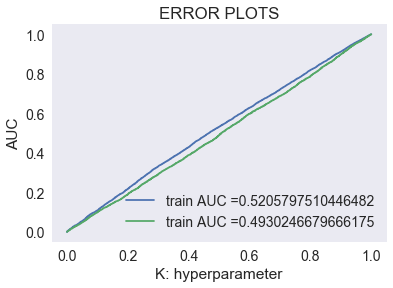

In [117]:
best_k = 1
from sklearn.metrics import roc_curve, auc


logreg3=LogisticRegression(penalty="l2",C=best_c)
                              
logreg3.fit(tfidf_train_sent_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = logreg3.predict_proba(tfidf_train_sent_vectors)[:,1]
y_test_pred = logreg3.predict_proba(tfidf_test_sent_vectors)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [118]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.2677194909157699 for threshold 0.84
Train confusion matrix
[[ 3332  2988]
 [16282 16798]]
Test confusion matrix
[[ 2320  2404]
 [12083 12159]]


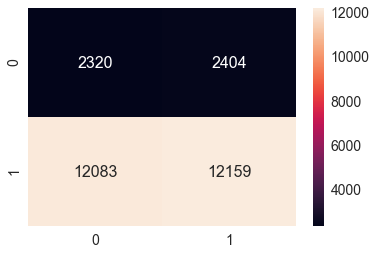

In [119]:
df_cm = pd.DataFrame((confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))), range(2),range(2)) 
sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [6] Conclusions

In [120]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "regularization", "Best Hypermeter ", "Best AUC"]

x.add_row(["BOW", "logistic regression"," L1",1,0.98])
x.add_row(["BOW", "logistic regression"," L2",1,0.99])
x.add_row(["TFIDF", "logistic regression", " L1",1,0.96])
x.add_row(["TFIDF", "logistic regression", " L2",11,0.98])
x.add_row(["Avg W2V", "logistic regression", " L1",1,0.89])
x.add_row(["Avg W2V", "logistic regression", " L2",1,0.90])
x.add_row(["TFIDF W2V", "logistic regression", " L1",50, 0.99])
x.add_row(["TFIDF W2V", "logistic regression", " L2",50, 0.99])
 
 

print(x)
 

+------------+---------------------+----------------+------------------+----------+
| Vectorizer |        Model        | regularization | Best Hypermeter  | Best AUC |
+------------+---------------------+----------------+------------------+----------+
|    BOW     | logistic regression |       L1       |        1         |   0.98   |
|    BOW     | logistic regression |       L2       |        1         |   0.99   |
|   TFIDF    | logistic regression |       L1       |        1         |   0.96   |
|   TFIDF    | logistic regression |       L2       |        11        |   0.98   |
|  Avg W2V   | logistic regression |       L1       |        1         |   0.89   |
|  Avg W2V   | logistic regression |       L2       |        1         |   0.9    |
| TFIDF W2V  | logistic regression |       L1       |        50        |   0.99   |
| TFIDF W2V  | logistic regression |       L2       |        50        |   0.99   |
+------------+---------------------+----------------+------------------+----